# Gesture Recognition
##Problem Statement:
A model that will be able to predict the 5 gestures correctly is to be built.Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

In [ ]:
# importing necessary packages
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import imageio
from imageio import imread
from skimage.transform import resize
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size =60 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,64,64,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:100, 0:100]
                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:100, 0:100]

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =8 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 8


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Architecture - 3D Convolution Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



## Model - 1

In [ ]:

#write your model here
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(30,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(64, activation='relu'))

# the output layer
model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 64, 64, 8)     656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 32, 32, 8)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 32, 32, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 32, 32, 16)    3472      
                                                                 
 conv3d_2 (Conv3D)           (None, 15, 32, 32, 16)    6928      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 16, 16, 16)    0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-13-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 60
Epoch 1/8
12/12 [==============================] - ETA: 0s - loss: 1.6107 - categorical_accuracy: 0.3213  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2023-08-0709_34_23.649611/model-00001-1.61071-0.32127-1.58938-0.28000.h5
12/12 [==============================] - 4364s 394s/step - loss: 1.6107 - categorical_accuracy: 0.3213 - val_loss: 1.5894 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/8
12/12 [==============================] - ETA: 0s - loss: 0.8219 - categorical_accuracy: 0.7014 
Epoch 2: saving model to model_init_2023-08-0709_34_23.649611/model-00002-0.82192-0.70136-1.59693-0.25000.h5
12/12 [==============================] - 402s 34s/step - loss: 0.8219 - categorical_accuracy: 0.7014 - val_loss: 1.5969 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/8
12/12 [==============================] - ETA: 0s - loss: 0.5286 -

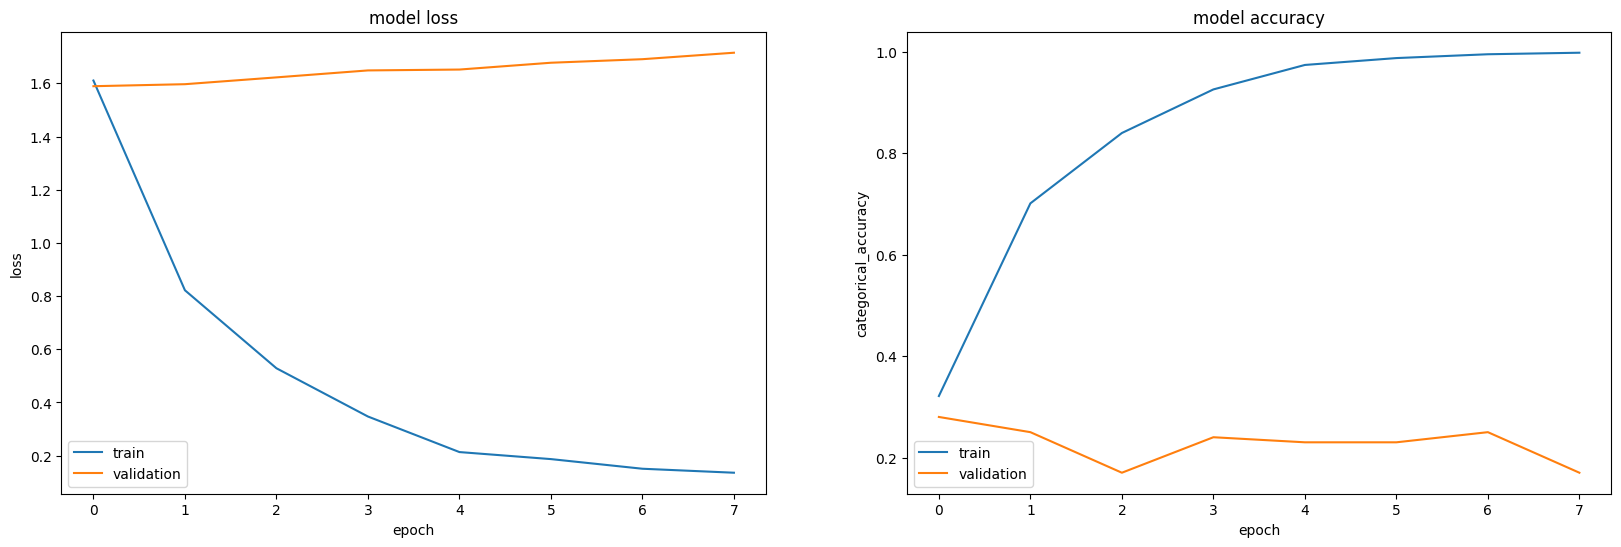

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model is performing very well on training but fails to perform well on validation data. So, there is overfitting. Let's add dropout layers and see if overfitting can be removed.

In [ ]:
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(30,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(64, activation='relu'))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 64, 64, 8)     656       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 32, 32, 8)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 32, 32, 8)    32        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 32, 32, 16)    3472      
                                                                 
 conv3d_2 (Conv3D)           (None, 15, 32, 32, 16)    6928      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 7, 16, 16, 16)    0

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-13-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 60
Epoch 1/8
12/12 [==============================] - ETA: 0s - loss: 1.8972 - categorical_accuracy: 0.3032 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 60

Epoch 1: saving model to model_init_2023-08-0714_06_41.729744/model-00001-1.89723-0.30317-1.59661-0.39000.h5
12/12 [==============================] - 440s 36s/step - loss: 1.8972 - categorical_accuracy: 0.3032 - val_loss: 1.5966 - val_categorical_accuracy: 0.3900 - lr: 2.0000e-04
Epoch 2/8
12/12 [==============================] - ETA: 0s - loss: 1.3393 - categorical_accuracy: 0.4465 
Epoch 2: saving model to model_init_2023-08-0714_06_41.729744/model-00002-1.33934-0.44646-1.60170-0.14000.h5
12/12 [==============================] - 432s 36s/step - loss: 1.3393 - categorical_accuracy: 0.4465 - val_loss: 1.6017 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/8
12/12 [==============================] - ETA: 0s - loss: 1.1157 - ca

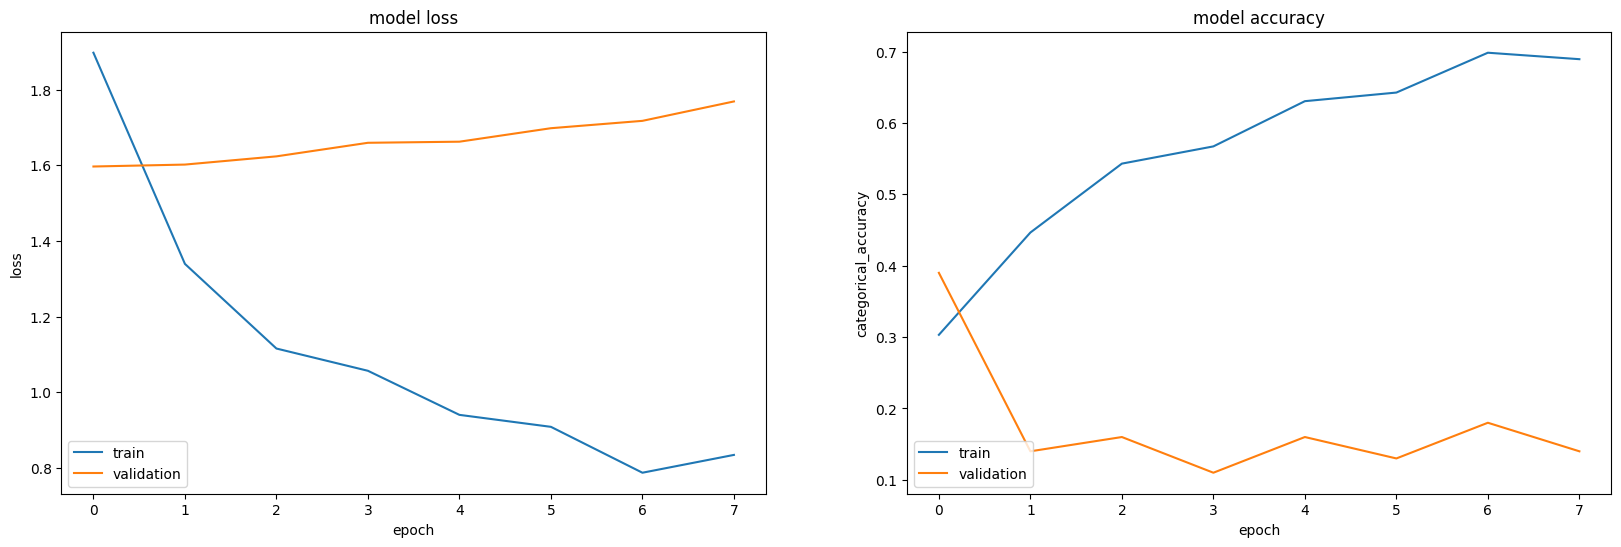

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model stills fails to perform on validation data. Let's make few changes on batch size, number of images in img_idx and no of epochs. This leads to changes in model architecture.

## Model - 2

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size =30

In [ ]:

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,3,5,7,9,11,13,15,17,19,20,22,24,26,29] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,64,64,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:100, 0:100]
                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:100, 0:100]

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(15,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(120, activation='relu'))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 15, 64, 64, 8)     656       
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 7, 32, 32, 8)     0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 7, 32, 32, 8)     32        
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 7, 32, 32, 16)     3472      
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 32, 32, 16)     6928      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 3, 16, 16, 16)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30


<ipython-input-23-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.8462 - categorical_accuracy: 0.3062Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0715_00_38.298412/model-00001-1.84616-0.30618-1.59018-0.24000.h5
23/23 [==============================] - 185s 8s/step - loss: 1.8462 - categorical_accuracy: 0.3062 - val_loss: 1.5902 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.2697 - categorical_accuracy: 0.5143
Epoch 2: saving model to model_init_2023-08-0715_00_38.298412/model-00002-1.26970-0.51433-1.67367-0.19000.h5
23/23 [==============================] - 176s 8s/step - loss: 1.2697 - categorical_accuracy: 0.5143 - val_loss: 1.6737 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 1.0596 - categorical_accuracy: 0.5792
Epoch 3: saving model to model_init_2023-08-0715_

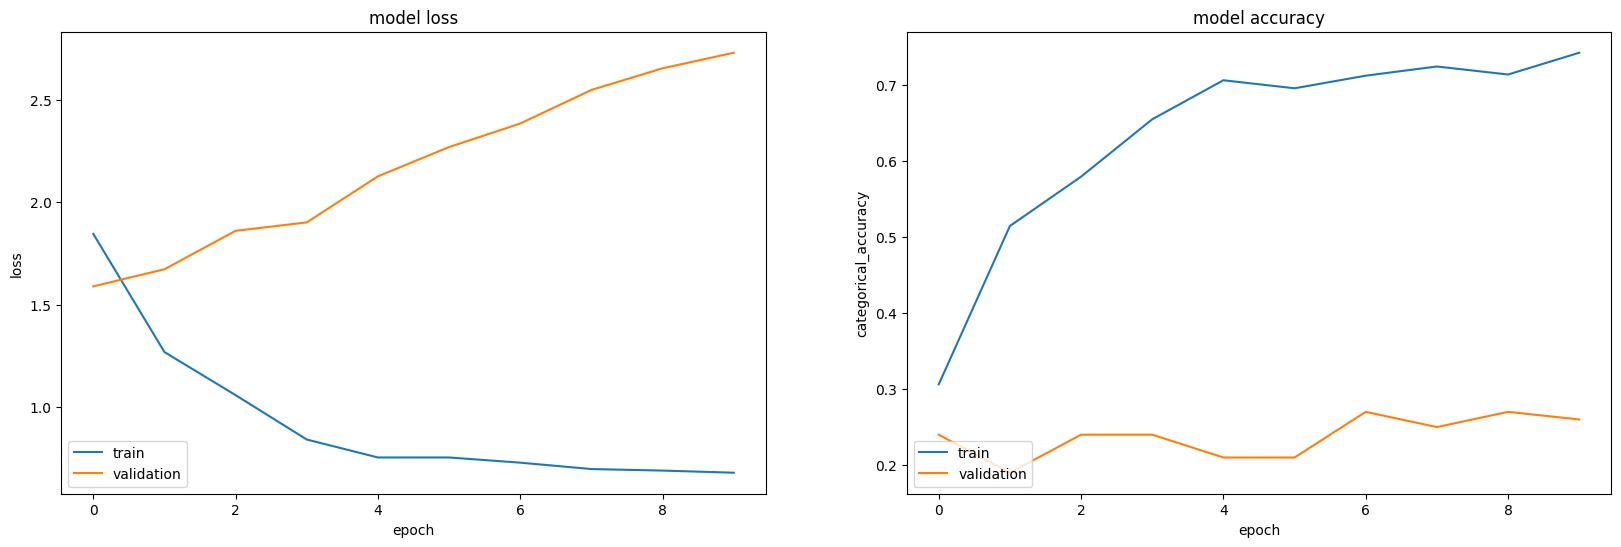

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

As the model still continues to perform poorly and is overfitted. Let's make some changes to the model architecture

## Model - 3

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size =30

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5,7,9,11,13,15,17,19,20,22,24,26] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,12,64,64,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:160, 0:160]
                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,12,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:160, 0:160]

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [ ]:
model = Sequential()


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same',input_shape=(12,64,64,3)))
model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(120, activation='relu'))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 64, 64, 16)    1312      
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 64, 64, 16)    6928      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 32, 32, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 32, 32, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 6, 32, 32, 32)     13856     
                                                                 
 conv3d_3 (Conv3D)           (None, 6, 32, 32, 32)     2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-21-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.6435 - categorical_accuracy: 0.3771  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0806_29_06.591229/model-00001-1.64353-0.37707-1.64220-0.16000.h5
23/23 [==============================] - 1617s 73s/step - loss: 1.6435 - categorical_accuracy: 0.3771 - val_loss: 1.6422 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.0778 - categorical_accuracy: 0.5701 
Epoch 2: saving model to model_init_2023-08-0806_29_06.591229/model-00002-1.07779-0.57014-1.80393-0.19000.h5
23/23 [==============================] - 475s 21s/step - loss: 1.0778 - categorical_accuracy: 0.5701 - val_loss: 1.8039 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.8168

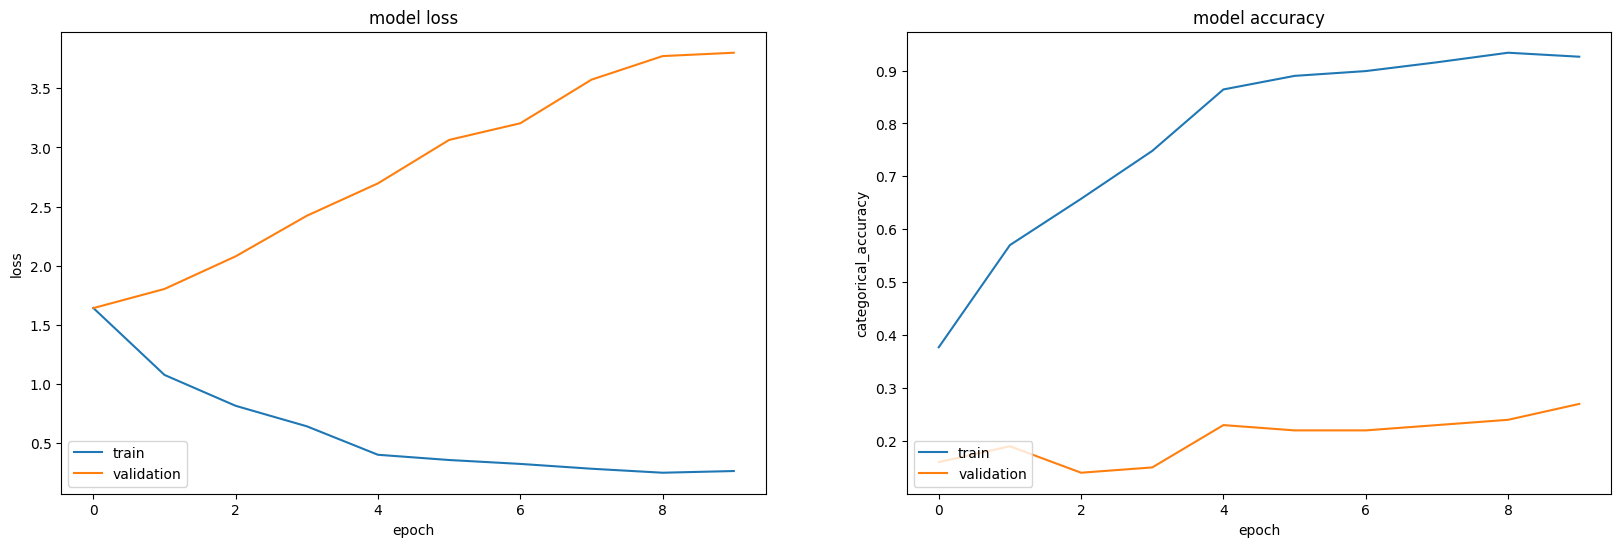

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model - 4

In [ ]:
model = Sequential()


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same',input_shape=(12,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 64, 64, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 32, 32, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 32, 32, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 32, 32, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 16, 16, 32)    0         
 3D)                                                             
                                                        

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

<ipython-input-15-40acd7b7729e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.3591 - categorical_accuracy: 0.4721  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0904_00_22.476424/model-00001-1.35911-0.47210-1.54905-0.19000.h5
23/23 [==============================] - 5862s 266s/step - loss: 1.3591 - categorical_accuracy: 0.4721 - val_loss: 1.5491 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 0.4765 - categorical_accuracy: 0.8341
Epoch 2: saving model to model_init_2023-08-0904_00_22.476424/model-00002-0.47654-0.83409-1.64458-0.29000.h5
23/23 [==============================] - 184s 8s/step - loss: 0.4765 - categorical_accuracy: 0.8341 - val_loss: 1.6446 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.2235 

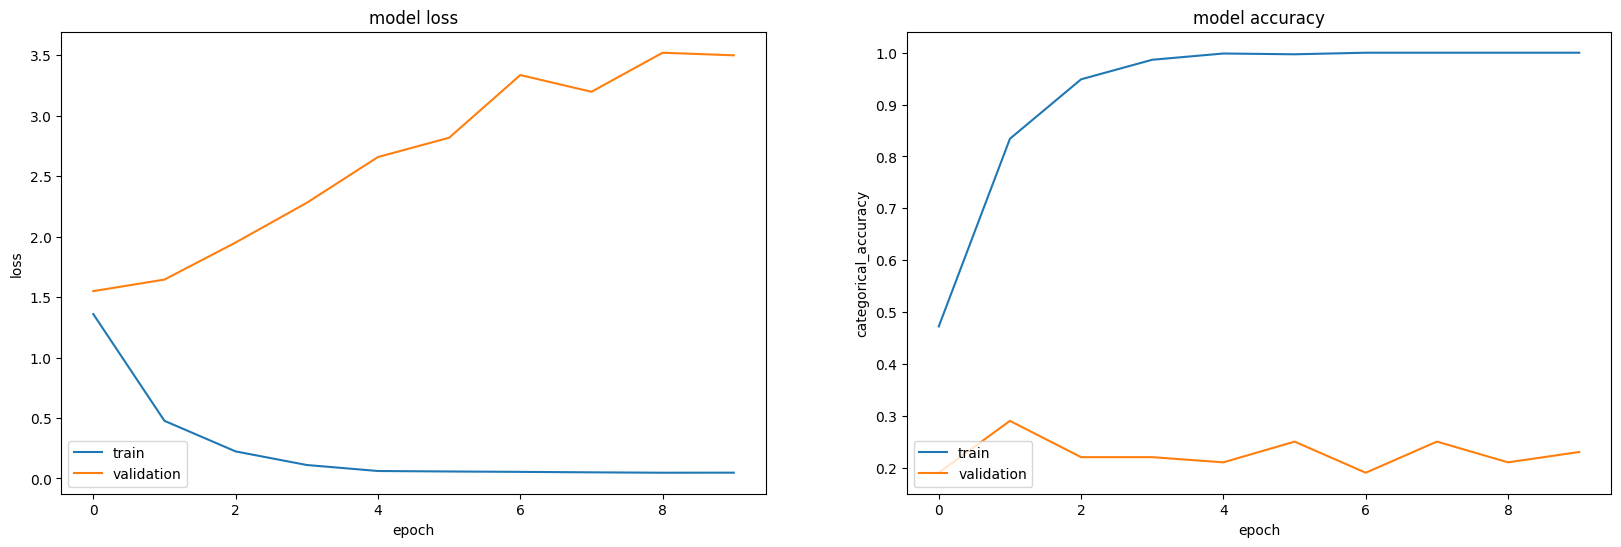

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

Let's add some dropout layers in this model and decrease the number of epochs.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


In [ ]:
model = Sequential()


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same',input_shape=(12,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(128, activation='relu'))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 12, 64, 64, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 32, 32, 16)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 32, 32, 16)    64        
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 32, 32, 32)     13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 16, 16, 32)    0         
 3D)                                                             
                                                        

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.7998 - categorical_accuracy: 0.3394Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0908_30_08.918770/model-00001-1.79981-0.33937-1.54277-0.25000.h5
23/23 [==============================] - 221s 10s/step - loss: 1.7998 - categorical_accuracy: 0.3394 - val_loss: 1.5428 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 0.9812 - categorical_accuracy: 0.6335
Epoch 2: saving model to model_init_2023-08-0908_30_08.918770/model-00002-0.98121-0.63348-1.68392-0.25000.h5
23/23 [==============================] - 195s 8s/step - loss: 0.9812 - categorical_accuracy: 0.6335 - val_loss: 1.6839 - val_categorical_accuracy: 0.2500 - lr: 2.0000e-04
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 0.6920 - categ

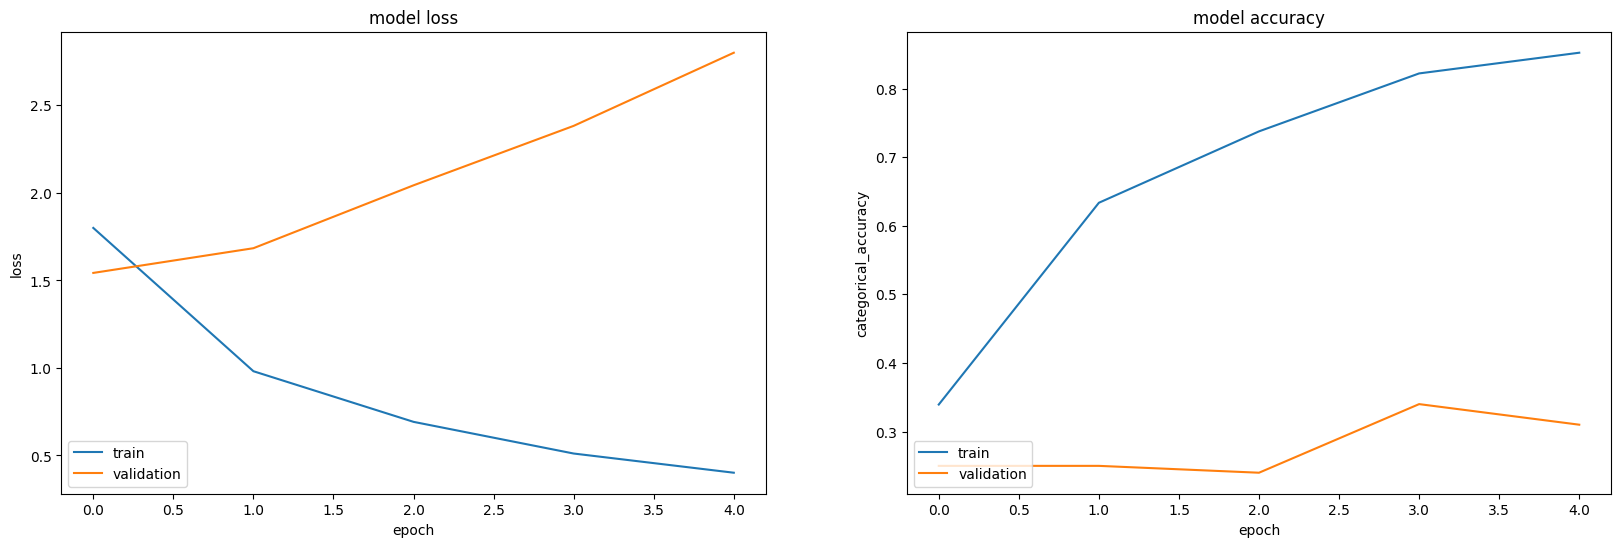

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model - 5

In [ ]:
model = Sequential()


model.add(Conv3D(64, (3,3,3), activation='relu', padding='same',input_shape=(12,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(8, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 32, 32, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 6, 32, 32, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 32, 32, 32)     55328     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 3, 16, 16, 32)    0         
 3D)                                                             
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.5774 - categorical_accuracy: 0.3409 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0908_30_08.918770/model-00001-1.57744-0.34087-1.63943-0.23000.h5
23/23 [==============================] - 457s 20s/step - loss: 1.5774 - categorical_accuracy: 0.3409 - val_loss: 1.6394 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.2863 - categorical_accuracy: 0.4902 
Epoch 2: saving model to model_init_2023-08-0908_30_08.918770/model-00002-1.28629-0.49020-1.67053-0.28000.h5
23/23 [==============================] - 442s 19s/step - loss: 1.2863 - categorical_accuracy: 0.4902 - val_loss: 1.6705 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.0942 - ca

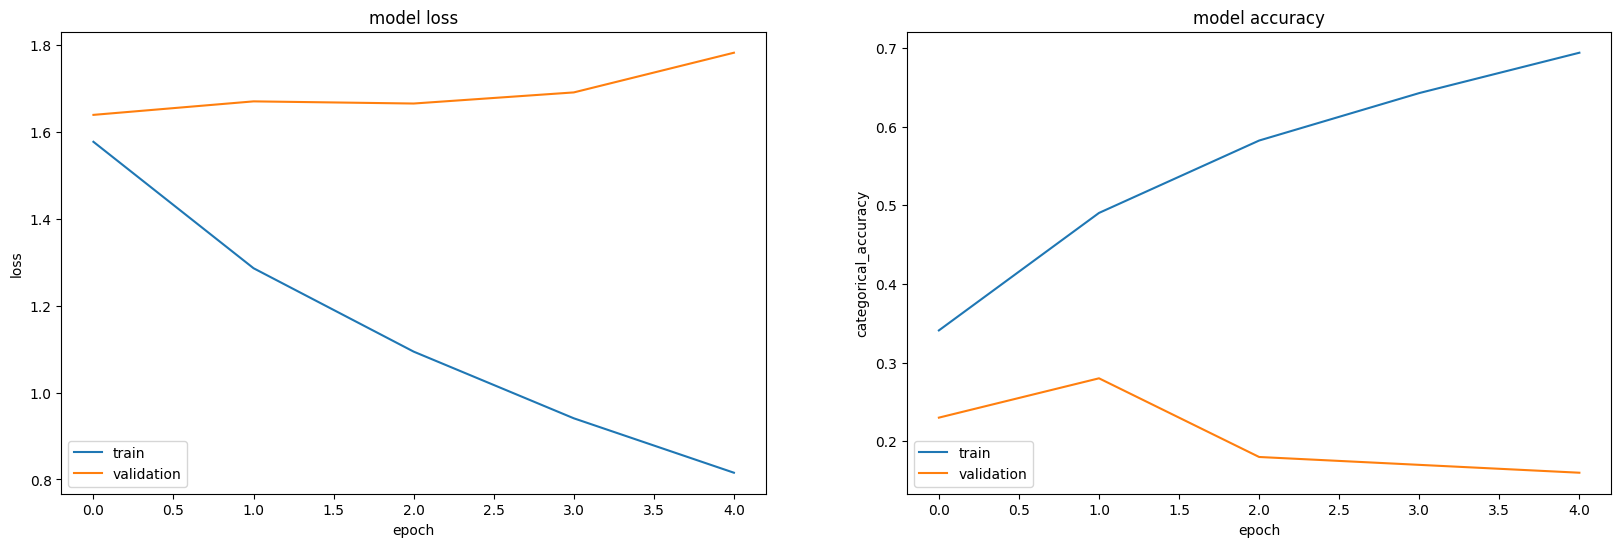

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

Let's add dropout layers in this model.

In [ ]:
model = Sequential()


model.add(Conv3D(64, (3,3,3), activation='relu', padding='same',input_shape=(12,64,64,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(8, activation='relu'))

# we will try to reduce overfitting by adding dropout
model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 32, 32, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 6, 32, 32, 64)    256       
 hNormalization)                                                 
                                                                 
 conv3d_7 (Conv3D)           (None, 6, 32, 32, 32)     55328     
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 3, 16, 16, 32)    0         
 3D)                                                             
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 30
Epoch 1/5
23/23 [==============================] - ETA: 0s - loss: 1.8965 - categorical_accuracy: 0.2383 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 30

Epoch 1: saving model to model_init_2023-08-0908_30_08.918770/model-00001-1.89650-0.23831-1.58535-0.24000.h5
23/23 [==============================] - 457s 20s/step - loss: 1.8965 - categorical_accuracy: 0.2383 - val_loss: 1.5853 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 2/5
23/23 [==============================] - ETA: 0s - loss: 1.5521 - categorical_accuracy: 0.3122 
Epoch 2: saving model to model_init_2023-08-0908_30_08.918770/model-00002-1.55209-0.31222-1.58404-0.31000.h5
23/23 [==============================] - 470s 20s/step - loss: 1.5521 - categorical_accuracy: 0.3122 - val_loss: 1.5840 - val_categorical_accuracy: 0.3100 - lr: 2.0000e-04
Epoch 3/5
23/23 [==============================] - ETA: 0s - loss: 1.4933 - ca

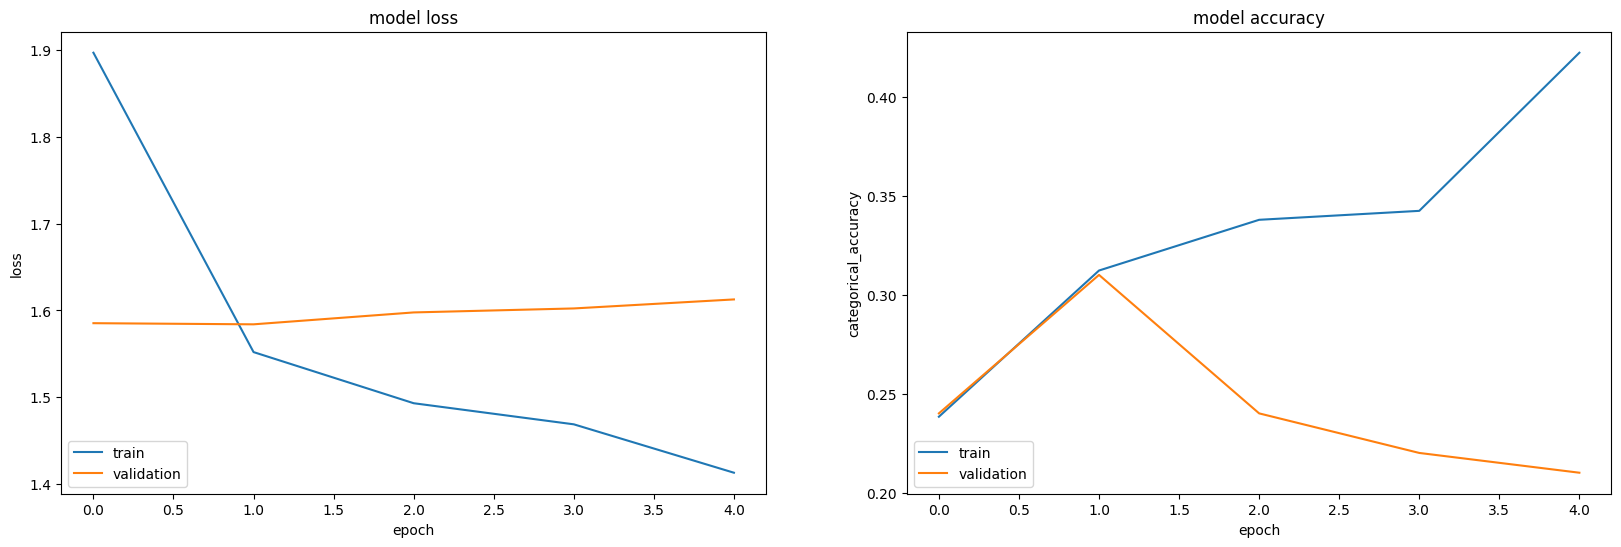

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Model - 6

Let's make changes in batch size,image size and architecture of the model.

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size =25

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [5,7,9,11,13,15,17,19,20,22,24,26] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches =int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,12,32,32,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:160, 0:160]
                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(32,32),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(32,32),interpolation = cv2.INTER_AREA).astype(np.float32)

                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255


                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


# write the code for the remaining data points which are left after full batches

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,12,32,32,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)

                    # crop the images and resize them. Note that the images are of 2 different shape
                    crop_img = image[0:160, 0:160]

                    # Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(32,32),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(32,32),interpolation = cv2.INTER_AREA).astype(np.float32)

                    # Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =5 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


In [ ]:
model = Sequential()


model.add(Conv3D(128, (3,3,3), activation='relu', padding='same',input_shape=(12,32,32,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(16, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 12, 32, 32, 128)   10496     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 batch_normalization_9 (Batc  (None, 6, 16, 16, 128)   512       
 hNormalization)                                                 
                                                                 
 conv3d_10 (Conv3D)          (None, 6, 16, 16, 64)     221248    
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 3, 8, 8, 64)      0         
 g3D)                                                            
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.5385 - categorical_accuracy: 0.3394 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0910_13_29.520441/model-00001-1.53846-0.33937-1.60141-0.30000.h5
27/27 [==============================] - 293s 11s/step - loss: 1.5385 - categorical_accuracy: 0.3394 - val_loss: 1.6014 - val_categorical_accuracy: 0.3000 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.0054 - categorical_accuracy: 0.6109
Epoch 2: saving model to model_init_2023-08-0910_13_29.520441/model-00002-1.00544-0.61086-1.61773-0.20000.h5
27/27 [==============================] - 274s 10s/step - loss: 1.0054 - categorical_accuracy: 0.6109 - val_loss: 1.6177 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 0.7142 - cat

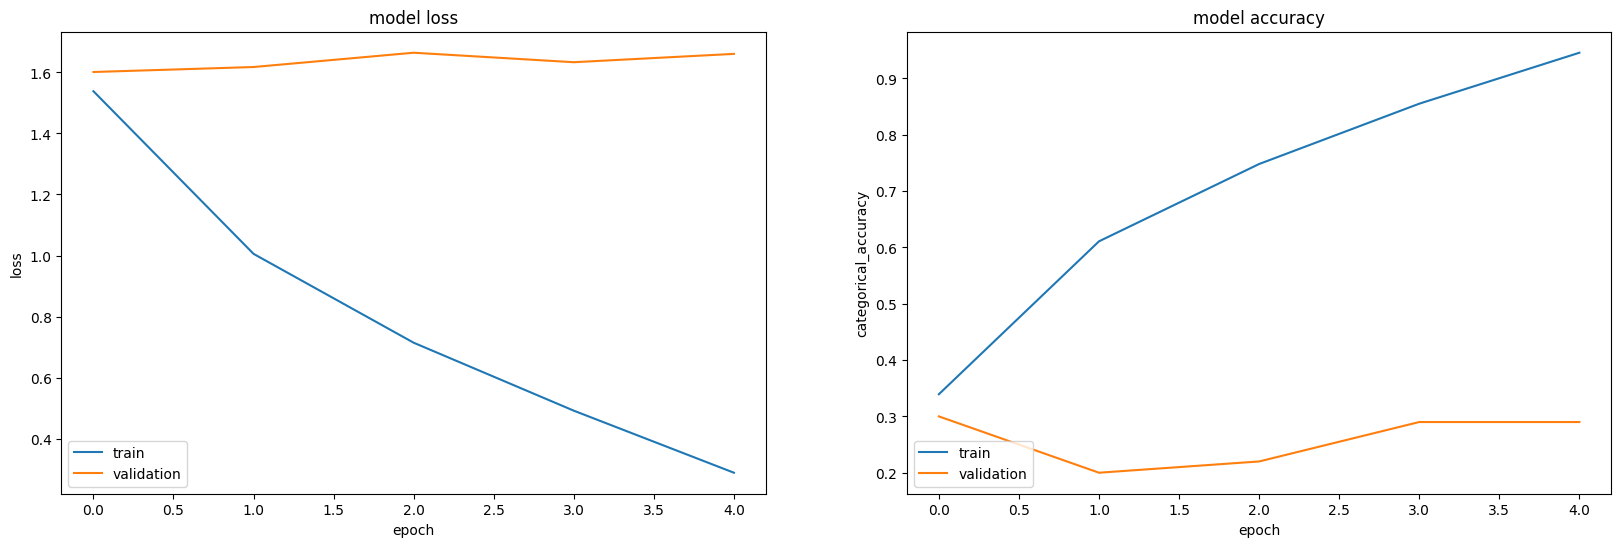

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model - 7

In [ ]:
model = Sequential()


model.add(Conv3D(64, (3,3,3), activation='relu', padding='same',input_shape=(12,32,32,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(16, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 12, 32, 32, 64)    5248      
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 6, 16, 16, 64)    0         
 g3D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 6, 16, 16, 64)    256       
 chNormalization)                                                
                                                                 
 conv3d_16 (Conv3D)          (None, 6, 16, 16, 32)     55328     
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 3, 8, 8, 32)      0         
 g3D)                                                            
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.4554 - categorical_accuracy: 0.3695Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0910_13_29.520441/model-00001-1.45536-0.36953-1.61345-0.16000.h5
27/27 [==============================] - 141s 5s/step - loss: 1.4554 - categorical_accuracy: 0.3695 - val_loss: 1.6134 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.0223 - categorical_accuracy: 0.5852
Epoch 2: saving model to model_init_2023-08-0910_13_29.520441/model-00002-1.02230-0.58522-1.73379-0.15000.h5
27/27 [==============================] - 135s 5s/step - loss: 1.0223 - categorical_accuracy: 0.5852 - val_loss: 1.7338 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 0.7008 - catego

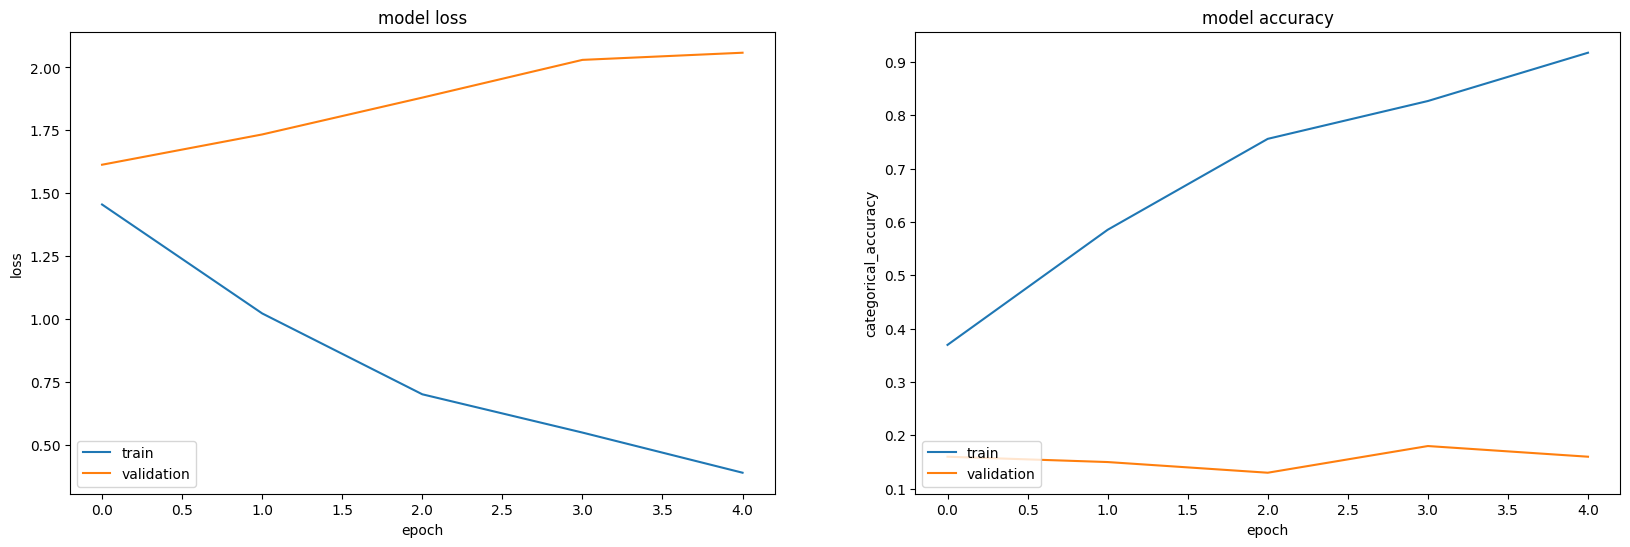

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model - 8

In [ ]:
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(12,32,32,3)))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.3))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(8, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 12, 32, 32, 8)     656       
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 6, 16, 16, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 6, 16, 16, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_28 (Conv3D)          (None, 6, 16, 16, 16)     3472      
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 3, 8, 8, 16)      0         
 g3D)                                                            
                                                      

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.8111 - categorical_accuracy: 0.1840Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0910_13_29.520441/model-00001-1.81105-0.18401-1.63780-0.23000.h5
27/27 [==============================] - 78s 3s/step - loss: 1.8111 - categorical_accuracy: 0.1840 - val_loss: 1.6378 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.5416 - categorical_accuracy: 0.3514
Epoch 2: saving model to model_init_2023-08-0910_13_29.520441/model-00002-1.54158-0.35143-1.60452-0.28000.h5
27/27 [==============================] - 82s 3s/step - loss: 1.5416 - categorical_accuracy: 0.3514 - val_loss: 1.6045 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.4377 - categori

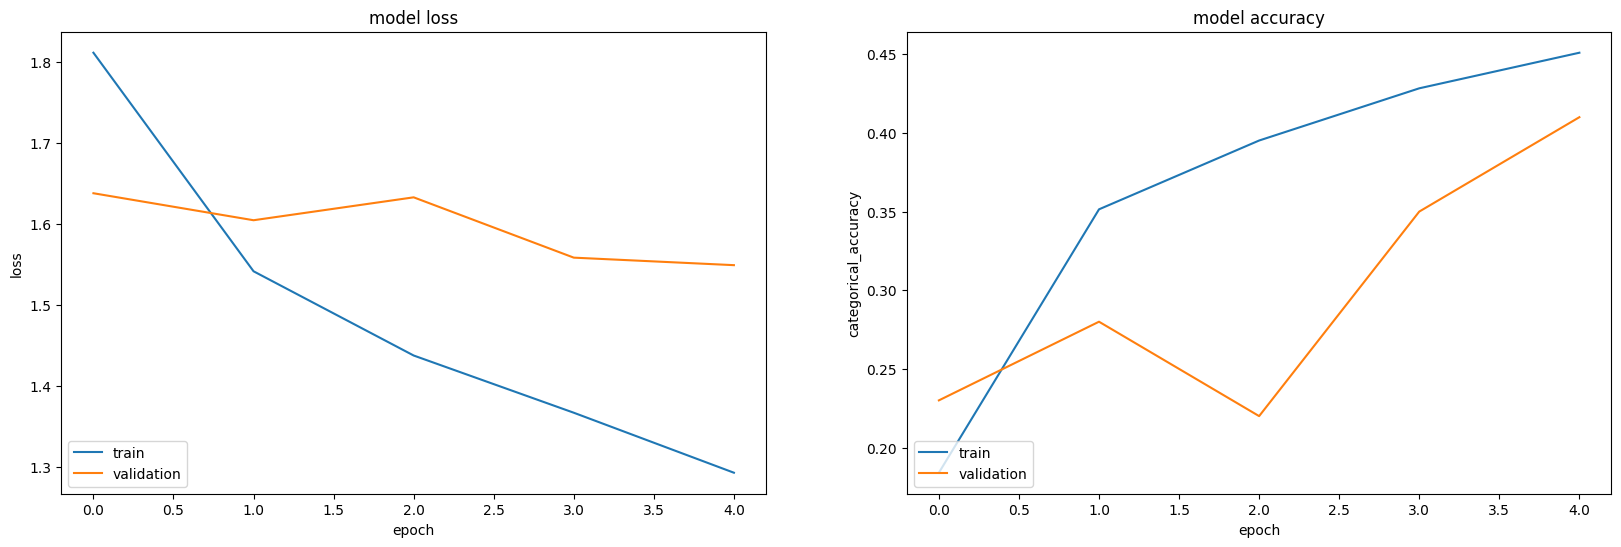

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## Model - 9

In [ ]:
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(12,32,32,3)))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(8, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_67 (Conv3D)          (None, 12, 32, 32, 8)     656       
                                                                 
 conv3d_68 (Conv3D)          (None, 12, 32, 32, 8)     1736      
                                                                 
 max_pooling3d_51 (MaxPoolin  (None, 6, 16, 16, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_51 (Bat  (None, 6, 16, 16, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_69 (Conv3D)          (None, 6, 16, 16, 16)     3472      
                                                                 
 conv3d_70 (Conv3D)          (None, 6, 16, 16, 16)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.7099 - categorical_accuracy: 0.2081Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0912_44_55.343993/model-00001-1.70990-0.20814-1.60581-0.29000.h5
27/27 [==============================] - 87s 3s/step - loss: 1.7099 - categorical_accuracy: 0.2081 - val_loss: 1.6058 - val_categorical_accuracy: 0.2900 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.5278 - categorical_accuracy: 0.3032
Epoch 2: saving model to model_init_2023-08-0912_44_55.343993/model-00002-1.52779-0.30317-1.60829-0.24000.h5
27/27 [==============================] - 82s 3s/step - loss: 1.5278 - categorical_accuracy: 0.3032 - val_loss: 1.6083 - val_categorical_accuracy: 0.2400 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.4285 - categori

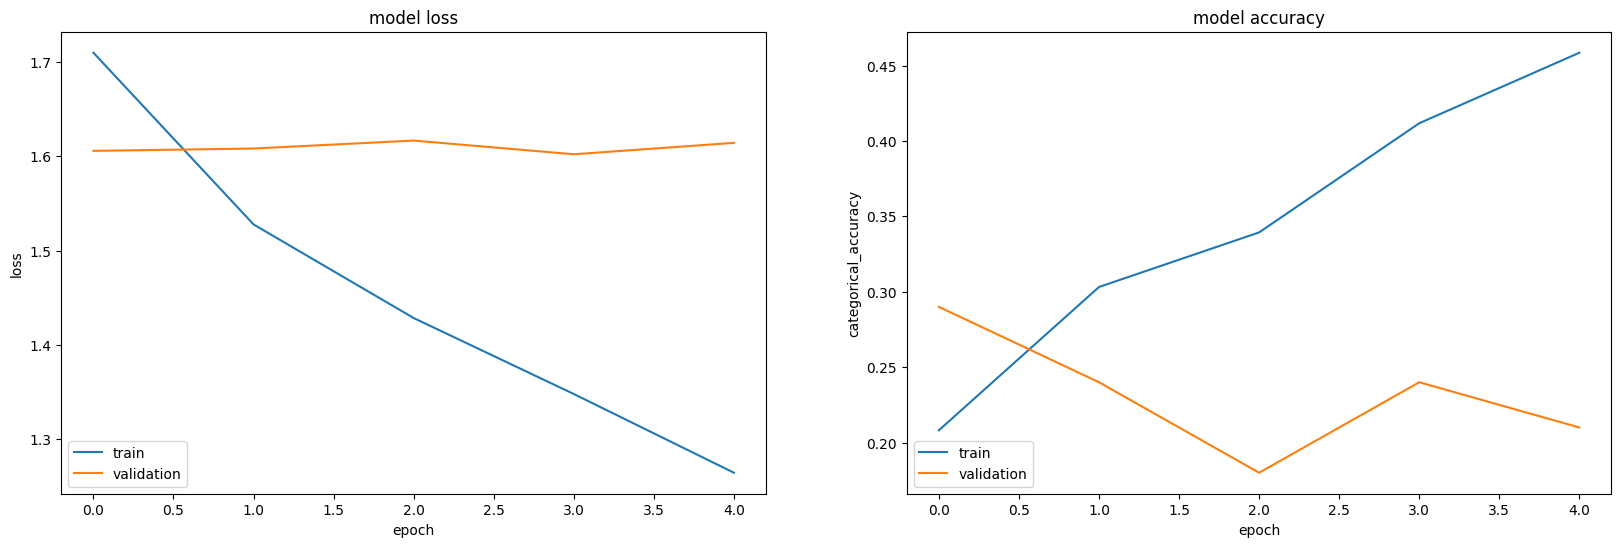

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [ ]:
model = Sequential()


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same',input_shape=(12,32,32,3)))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())


# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# convert layer into 1-D
model.add(Flatten())

# fully connected layer
model.add(Dense(8, activation='relu'))

# we will try to reduce overfitting by adding dropout
#model.add(Dropout(0.25))

# the output layer
model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser =optimizers.Adam(lr=0.0002) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_74 (Conv3D)          (None, 12, 32, 32, 8)     656       
                                                                 
 conv3d_75 (Conv3D)          (None, 12, 32, 32, 8)     1736      
                                                                 
 max_pooling3d_54 (MaxPoolin  (None, 6, 16, 16, 8)     0         
 g3D)                                                            
                                                                 
 batch_normalization_54 (Bat  (None, 6, 16, 16, 8)     32        
 chNormalization)                                                
                                                                 
 conv3d_76 (Conv3D)          (None, 6, 16, 16, 8)      1736      
                                                                 
 conv3d_77 (Conv3D)          (None, 6, 16, 16, 8)    

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 25
Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 1.7958 - categorical_accuracy: 0.2383Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 25

Epoch 1: saving model to model_init_2023-08-0912_44_55.343993/model-00001-1.79581-0.23831-1.61064-0.16000.h5
27/27 [==============================] - 96s 3s/step - loss: 1.7958 - categorical_accuracy: 0.2383 - val_loss: 1.6106 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.4958 - categorical_accuracy: 0.3228
Epoch 2: saving model to model_init_2023-08-0912_44_55.343993/model-00002-1.49579-0.32278-1.60773-0.19000.h5
27/27 [==============================] - 79s 3s/step - loss: 1.4958 - categorical_accuracy: 0.3228 - val_loss: 1.6077 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.4111 - categori

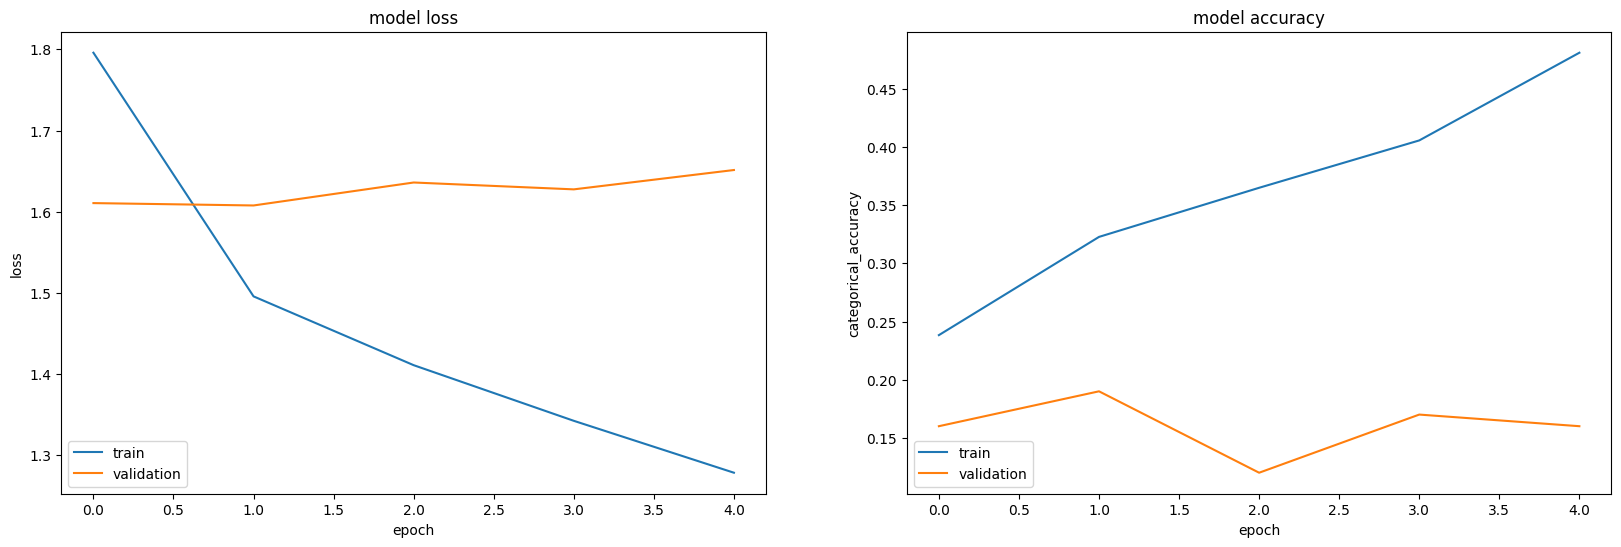

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Architecture - 2: Conv2D + RNN

In [ ]:
#project_data_path = "C:\\Users\\rakes\\Desktop\\Project_data"
project_data_path = "/home/datasets/Project_data" #uncomment for jarvis/google colab


train_doc = np.random.permutation(open(project_data_path +'/train.csv').readlines())
val_doc = np.random.permutation(open(project_data_path +'/val.csv').readlines())
batch_size = 30 #experiment with the batch size
dim_x, dim_y = 120, 120
images_sequence = range(2,26,2)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-08-07 19:42:22.913680: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-08-07 19:42:22.913742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = images_sequence#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))


                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path =  project_data_path + '/train'
val_path = project_data_path + '/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


Source path =  /home/datasets/Project_data/train ; batch size = 1


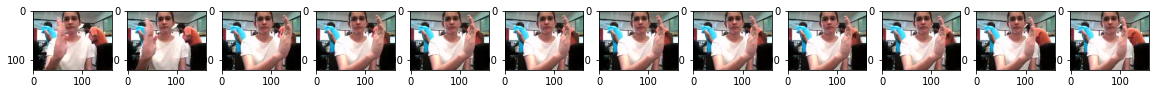

In [ ]:
# testing generative
test_gen = generator(train_path, train_doc, 1, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 CNN+ GRU

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Dropout, TimeDistributed, Flatten, BatchNormalization, Activation,GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import LSTM

input_shape = (len(images_sequence), dim_x, dim_y, 3)

#write your model here
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2023-08-07 19:42:32.091758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 12, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 12, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 12, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 12, 28, 28, 64)   0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.6525 - categorical_accuracy: 0.3609Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2023-08-0621_42_03.599930/model-00001-1.65251-0.36087-2.23289-0.19167.h5
23/23 [==============================] - 68s 3s/step - loss: 1.6525 - categorical_accuracy: 0.3609 - val_loss: 2.2329 - val_categorical_accuracy: 0.1917 - lr: 0.0100
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.0720 - categorical_accuracy: 0.4826
Epoch 00002: saving model to model_init_2023-08-0621_42_03.599930/model-00002-1.07197-0.48261-1.89119-0.16667.h5
23/23 [==============================] - 64s 3s/step - loss: 1.0720 - categorical_accuracy: 0.4826 - val_loss: 1.8912 - val_categorical_accuracy: 0.1667 - lr: 0.0100
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0147 - categorical_accuracy:

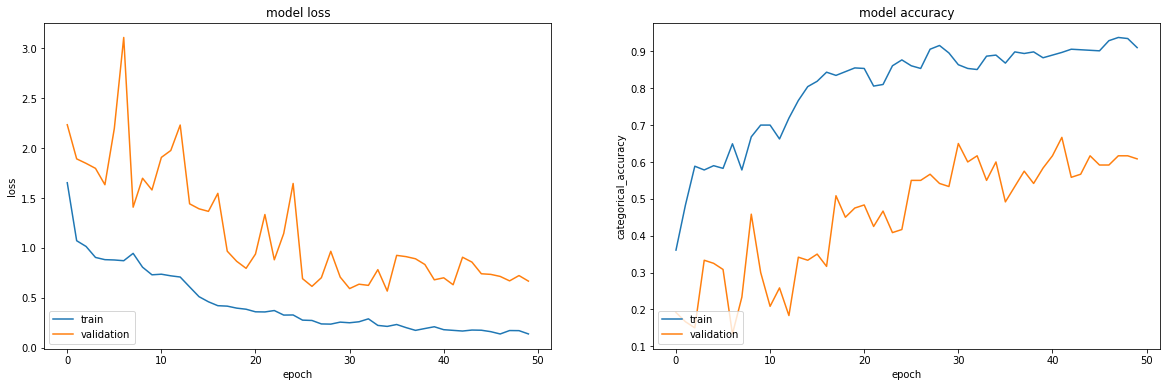

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Insights
- Traning is overfitting and got accuracy of 90% and 60% on validation
- changing layer by adding drop outs

### Model 2 CNN+ GRU

In [ ]:

model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 12, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 12, 118, 118, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 12, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 12, 111392)       0         
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 128)              

### Traning the model

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/50


2023-08-07 08:23:50.854186: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.6637 - categorical_accuracy: 0.2493Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2023-08-0708_22_46.067232/model-00001-1.66372-0.24928-1.64770-0.31667.h5
23/23 [==============================] - 70s 3s/step - loss: 1.6637 - categorical_accuracy: 0.2493 - val_loss: 1.6477 - val_categorical_accuracy: 0.3167 - lr: 0.0100
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.4421 - categorical_accuracy: 0.3261
Epoch 00002: saving model to model_init_2023-08-0708_22_46.067232/model-00002-1.44214-0.32609-1.80959-0.15000.h5
23/23 [==============================] - 65s 3s/step - loss: 1.4421 - categorical_accuracy: 0.3261 - val_loss: 1.8096 - val_categorical_accuracy: 0.1500 - lr: 0.0100
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.5076 - categorical_accuracy: 0.3275
Epoch 00003: saving model to model_init_2023-08-0708_22_46.067232/mode

### Insights:
- Adding drop out helped to remove overfitting
- let's try changing batch_size and epochs

In [ ]:
batch_size = 5
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20


2023-08-07 17:05:15.445184: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


133/133 [==============================] - ETA: 0s - loss: 1.7675 - categorical_accuracy: 0.3338Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2023-08-0717_04_04.539041/model-00001-1.76754-0.33383-2.29649-0.25000.h5
133/133 [==============================] - 65s 464ms/step - loss: 1.7675 - categorical_accuracy: 0.3338 - val_loss: 2.2965 - val_categorical_accuracy: 0.2500 - lr: 0.0100
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.5263 - categorical_accuracy: 0.3278
Epoch 00002: saving model to model_init_2023-08-0717_04_04.539041/model-00002-1.52627-0.32782-1.93302-0.24000.h5
133/133 [==============================] - 61s 462ms/step - loss: 1.5263 - categorical_accuracy: 0.3278 - val_loss: 1.9330 - val_categorical_accuracy: 0.2400 - lr: 0.0100
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.4544 - categorical_accuracy: 0.3414
Epoch 00003: saving model to model_init_2023-08-0717_04

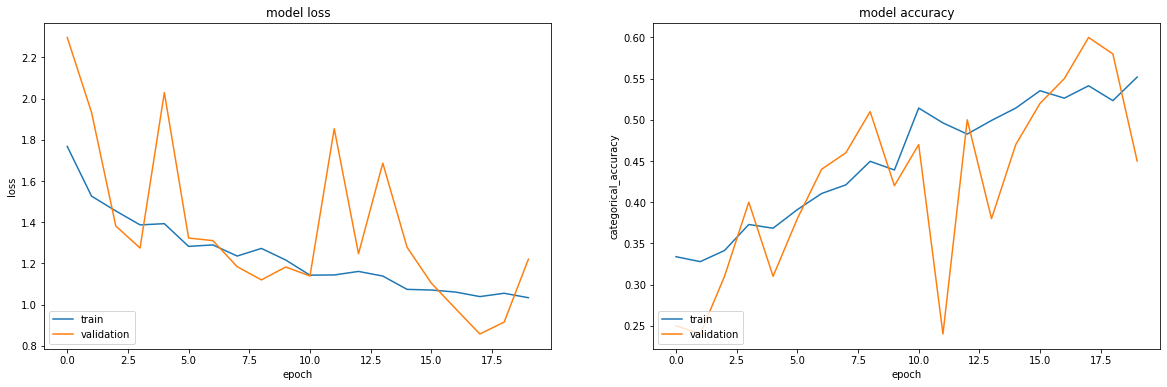

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Insights
- after reducing we can see that 55% and 45% on traning and validation respectively
- let's try adding augmentation

### Model 3 CNN+ GRU by Augmentation

In [ ]:
images_sequence = range(2,26,2)
def generator(source_path, folder_list, batch_size, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = images_sequence#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                aug_type = None
                if rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))
                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches


In [ ]:
batch_size = 5
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 5
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.9885 - categorical_accuracy: 0.2120Source path =  /home/datasets/Project_data/val ; batch size = 5

Epoch 00001: saving model to model_init_2023-08-0717_42_21.195077/model-00001-1.98852-0.21203-1.66400-0.23000.h5
133/133 [==============================] - 60s 454ms/step - loss: 1.9885 - categorical_accuracy: 0.2120 - val_loss: 1.6640 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.9434 - categorical_accuracy: 0.2015
Epoch 00002: saving model to model_init_2023-08-0717_42_21.195077/model-00002-1.94340-0.20150-2.03930-0.23000.h5
133/133 [==============================] - 60s 454ms/step - loss: 1.9434 - categorical_accuracy: 0.2015 - val_loss: 2.0393 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.7423 - categor

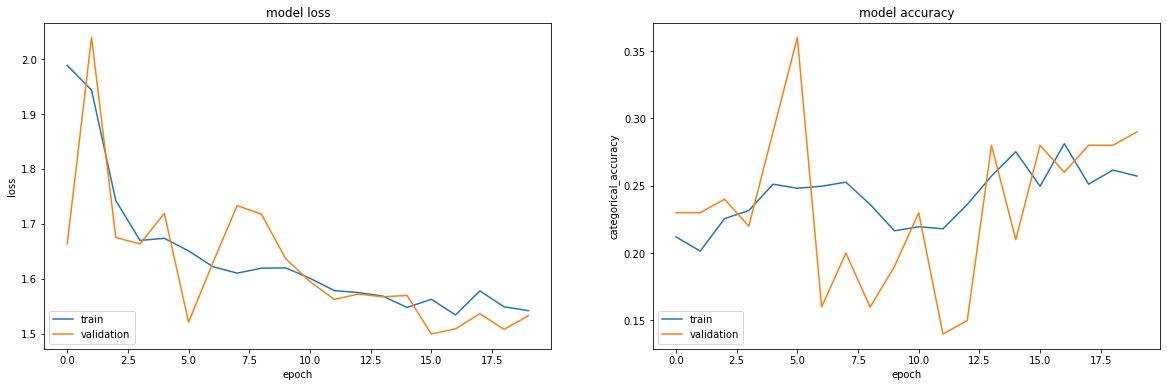

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Insights
- clearly by adding augmentation reduced accuracy with layer changes

### Model 3 CNN+ GRU by increasing epoch and batch size

In [ ]:
images_sequence = range(2,26,2)
def generator(source_path, folder_list, batch_size, debug=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = images_sequence#create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

                    resized_im = resize(image, (y,z))

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255#normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



In [ ]:
batch_size = 30
num_epochs = 50
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.3559 - categorical_accuracy: 0.3319Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2023-08-0717_42_21.195077/model-00001-1.35585-0.33188-1.16871-0.25833.h5
23/23 [==============================] - 63s 3s/step - loss: 1.3559 - categorical_accuracy: 0.3319 - val_loss: 1.1687 - val_categorical_accuracy: 0.2583 - lr: 0.0020
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.3157 - categorical_accuracy: 0.3464
Epoch 00002: saving model to model_init_2023-08-0717_42_21.195077/model-00002-1.31571-0.34638-1.17697-0.22500.h5
23/23 [==============================] - 61s 3s/step - loss: 1.3157 - categorical_accuracy: 0.3464 - val_loss: 1.1770 - val_categorical_accuracy: 0.2250 - lr: 0.0020
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.2839 - categorical_accuracy:

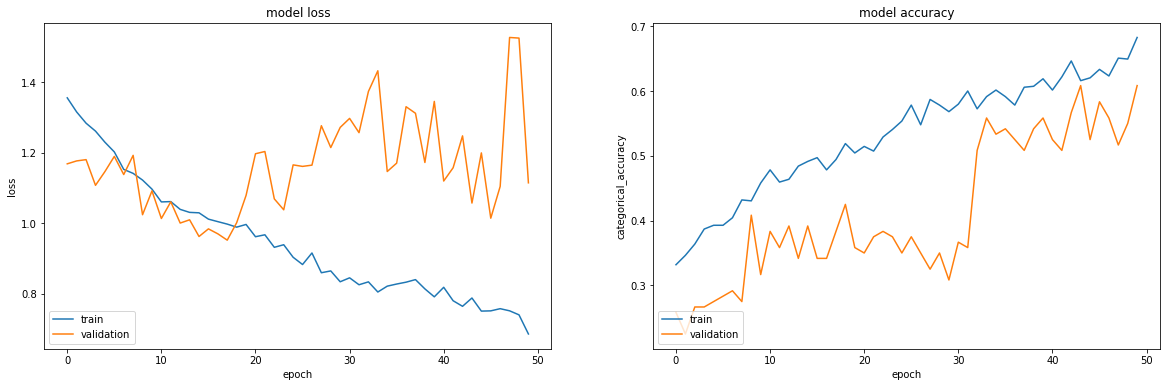

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Insights
- Cleary we got better results 69%  and 61% on traning and validation
- let's try changing conv and RNN layers to check if it improves

### Model 4 with CNN + RNN + GRU with less batchsize and epoch

In [ ]:
input_shape = (len(images_sequence), dim_x, dim_y, 3)

#write your model here
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())

model.add(TimeDistributed(
     Conv2D(64, (3,3), activation='relu'))
 )
model.add(TimeDistributed(
     MaxPooling2D((2,2)))
 )
model.add(BatchNormalization())
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(GRU(128))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = tf.optimizers.Adam(lr=0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 12, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 12, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 12, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 12, 28, 28, 64)  

In [ ]:
batch_size = 20
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6432 - categorical_accuracy: 0.3544Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2023-08-0717_42_21.195077/model-00001-1.64319-0.35441-2.93397-0.23000.h5
34/34 [==============================] - 66s 2s/step - loss: 1.6432 - categorical_accuracy: 0.3544 - val_loss: 2.9340 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2527 - categorical_accuracy: 0.4118
Epoch 00002: saving model to model_init_2023-08-0717_42_21.195077/model-00002-1.25267-0.41176-3.40833-0.19000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.2527 - categorical_accuracy: 0.4118 - val_loss: 3.4083 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1422 - categorical_accuracy:

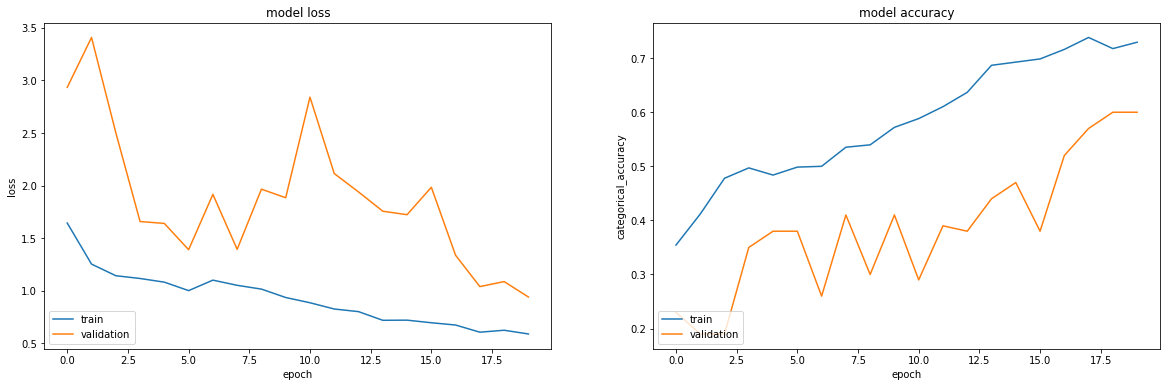

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Insights
- Cleary we got better results 72%  and 60% on traning and validation
- let's try changing to LSTM with has more trainable parameters

### Model 5 with CNN+ RNN+ LSTM

In [ ]:
model = Sequential()
model.add(TimeDistributed(
     Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
 )
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(128))
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5, activation='softmax'))

In [ ]:
optimiser = tf.optimizers.Adam(lr=0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 12, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 12, 118, 118, 32)  128      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 12, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 12, 111392)       0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)              

In [ ]:
batch_size = 20
num_epochs = 20
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20


2023-08-07 19:43:12.796615: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.6161 - categorical_accuracy: 0.2912Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2023-08-0719_42_28.262063/model-00001-1.61606-0.29118-2.00621-0.18000.h5
34/34 [==============================] - 65s 2s/step - loss: 1.6161 - categorical_accuracy: 0.2912 - val_loss: 2.0062 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4383 - categorical_accuracy: 0.3162
Epoch 00002: saving model to model_init_2023-08-0719_42_28.262063/model-00002-1.43833-0.31618-2.12650-0.20000.h5
34/34 [==============================] - 63s 2s/step - loss: 1.4383 - categorical_accuracy: 0.3162 - val_loss: 2.1265 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.4171 - categorical_accuracy: 0.3588
Epoch 00003: saving model to model_init_2023-08-0719_42_28.262063/mode

### Insights
- using LSTM got only 31% accuracy on traning data and 34% on valication accuracy

#### model-00020-0.58814-0.72941-0.93977-0.60000.h5 has best model out of all trained models

#### which comes from the Model 4 with CNN + RNN + GRU with less batchsize and epoch if we can increase epoch and batch size accuaracy might increased

#### (Training Accuracy : 73%, Validation Accuracy : 62%)
